In [ ]:
from dolfinx import fem, mesh, io
import dolfinx.fem.petsc as petsc
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI
import ufl
import matplotlib.pyplot as plt
from typing import Any
import gotranx
%reload_ext autoreload 
from pathlib import Path

In [5]:
import monodomain 

In [50]:
%autoreload
monodomain.translateODE("simple", [gotranx.schemes.Scheme.forward_explicit_euler, gotranx.schemes.Scheme.generalized_rush_larsen])

2024-11-26 16:44:01 [info     ] Load ode /Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/simple.ode
2024-11-26 16:44:01 [info     ] Num states 2                  
2024-11-26 16:44:01 [info     ] Num parameters 0              


In [71]:
def initial_v(x):
    return -85*np.cos(2*np.pi * x[0])

def initial_s(x):
    return 0*x[0]

def I_stim(x, t, lam, M):
    condition = ufl.And(x[0]<0.5, x[1]<0.5)
    return 2 * ufl.sin(t) *ufl.conditional(condition, 60, 0)

In [72]:
%autoreload

h = 0.05
dt = 0.01
theta = 0.5
pde = monodomain.PDESolver(h, dt, theta, M = 1, lam = 1)

N = int(np.ceil(1/h))
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
pde.set_mesh(domain, lagrange_order=2)
pde.initialize_vn(initial_v)

pde.set_stimulus(I_stim)
pde.setup_solver()

sn = pde.interpolate_func(initial_s)
ode = monodomain.ODESolver(odefile="fitzhughnagumo", scheme="generalized_rush_larsen", initial_v=pde.vn, initial_states=[sn], state_names=["s"])
ode.set_param("stim_amplitude", 0)

solver = monodomain.MonodomainSolver(pde, ode)
vn, x, t = solver.solve(T=10, vtx_title="fitz")

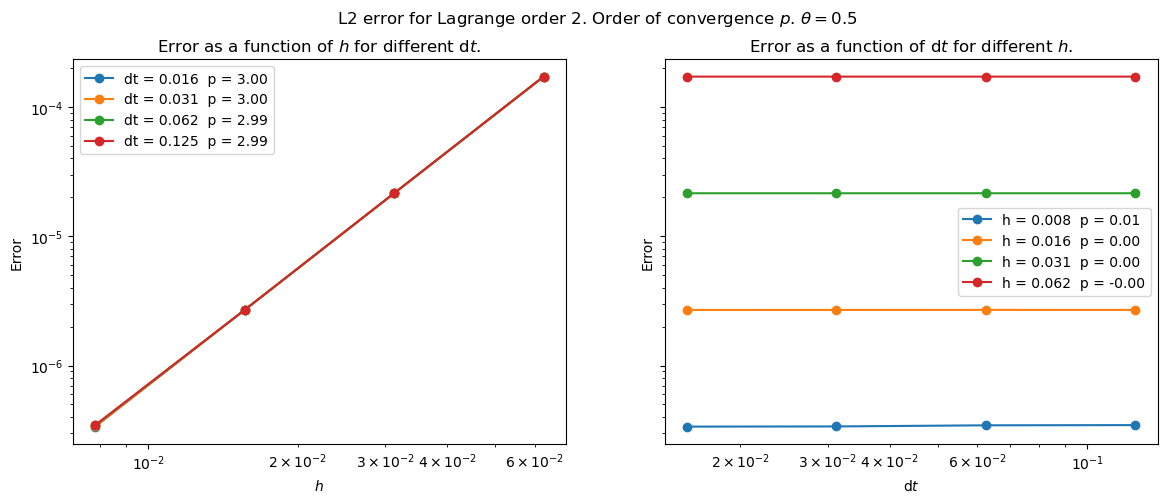

In [104]:
import tests
%autoreload
tests.convergence_plot(4, 4, start_spatial=3, start_temporal=2, theta=0.5, lagrange_order=2)


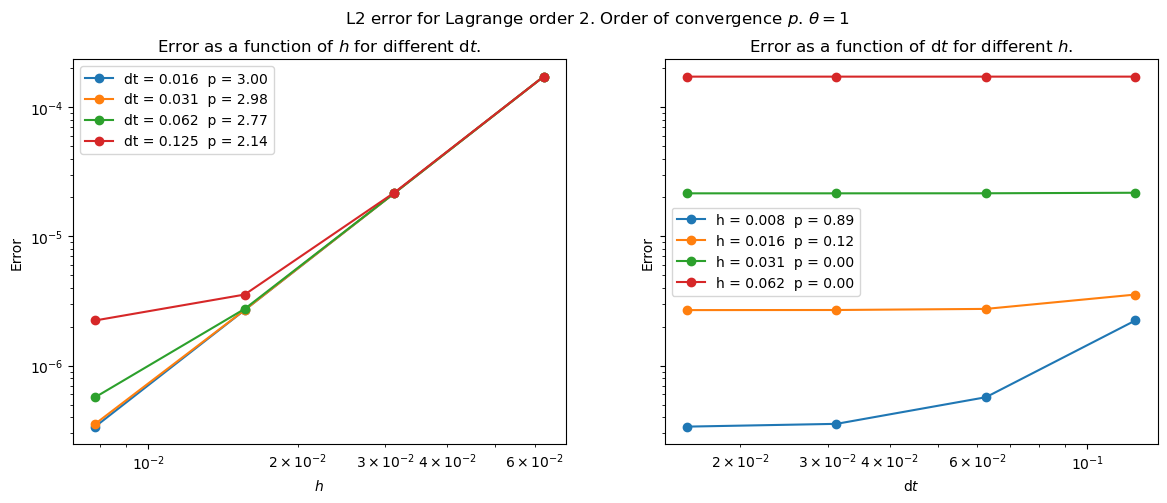

In [ ]:
tests.convergence_plot(4, 4, start_spatial=3, start_temporal=2, theta=1, lagrange_order=2)

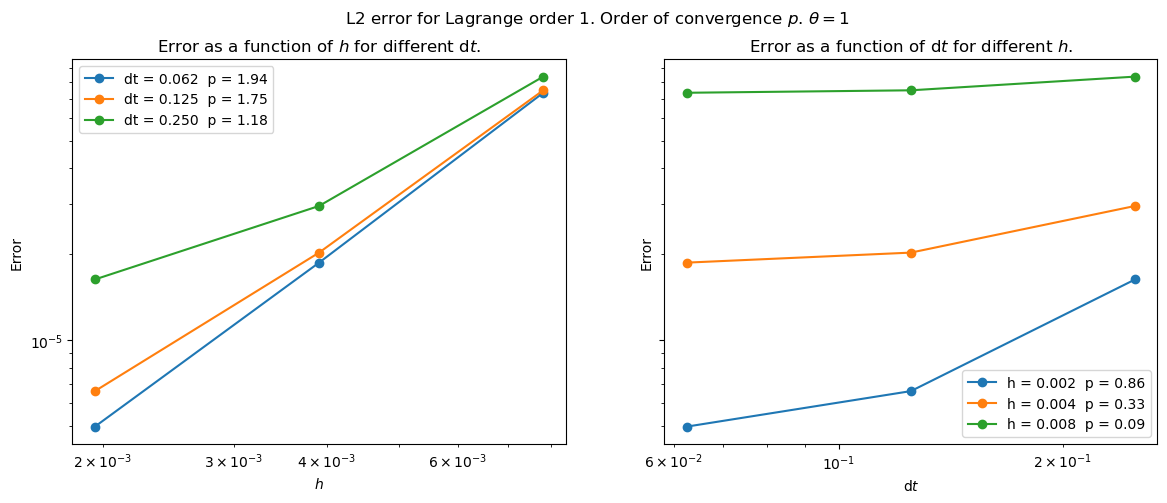

In [ ]:
tests.convergence_plot(3, 3, start_spatial=7, start_temporal=1, theta=1, lagrange_order=1)

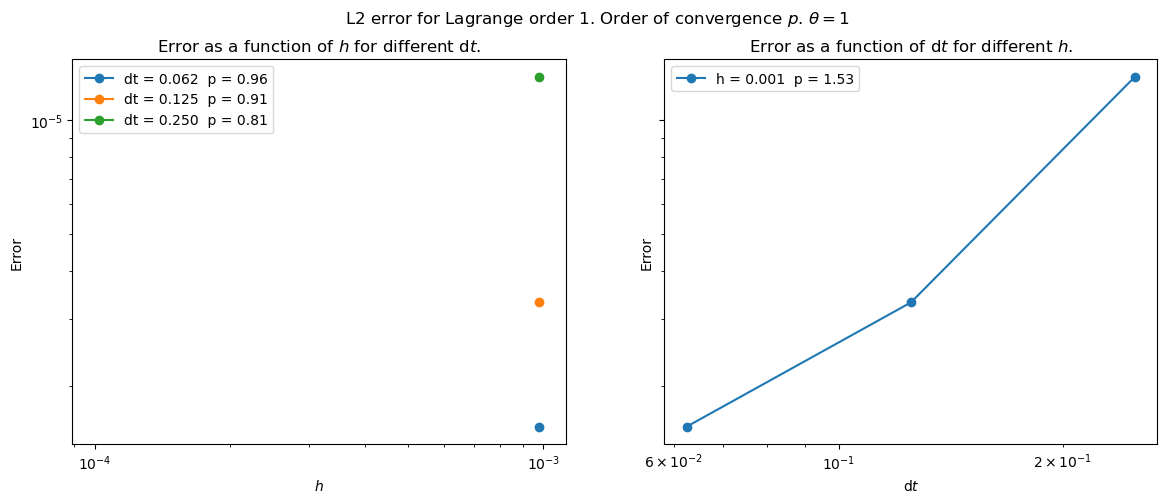

In [112]:
tests.convergence_plot(1, 3, start_spatial=9, start_temporal=1, theta=1, lagrange_order=1)
